## - Introduction to Machine Learning and Data Mining - <br> <br> <i> Project 3: Unsupervised Machine Learning </i>

### **_by Sebastian Sbirna_**

***

In this report, we will evaluate the performance and characteristics of various types of unsupervised learning models upon our chosen Heart Disease dataset. For more information upon the data dictionary and a description of the properties of our observations and attributes, please refer to our former project [1].

In [229]:
import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, hist, plot, legend, xlabel, title, ylim, imshow, bar, xticks, yticks, cm, subplot

from sklearn.mixture import GaussianMixture
from sklearn import model_selection
from sklearn.cluster import k_means
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy import stats

from toolbox_02450 import clusterplot, clusterval, gausKernelDensity

from similarity import binarize2
from apyori import apriori

import warnings
warnings.filterwarnings('ignore')

Our dataset was initially collected for classification purposes, having 14 attributes: 5 numerical and 9 categorical. Out of the 14 attributes, there exists one ‘target’ variable which should be predicted in a classification setting. Since our original dataset includes 9 categorical variables, when performing unsupervised learning analysis, it is necessary to encode them using the one-out-of-K method, so that the machine learning methods will not understand the numerical category mappings as continuous values. After this feature transformation, from a total of 14 original variables, we end up with 30 variables (including the criterion variable).

For clustering and outlier detection, we will separate the predictor variables into an **_X_** matrix, and the criterion variable will be lying in a separate _**y**_ vector, however, for association mining, since we are also interested in discovering rules between values of predictor variables and values of the criterion (_y_) variable, we will one-out-of-K encode the two possibilities for the criterion variable ‘target’ (which refers to whether a person is identified to have angiographic heart disease) and include them in our matrix X for completeness of rule searching.

### I.  Clustering

This section will contain information about different methods in which clustering of our dataset can be performed, and reflections as to how well the found clusters reflect the labelled information. The original problem is well-suited for a cluster separation, since it was a classification problem where we predicted the disease status of our observations (i.e. patients). In unsupervised learning, we are not fitting the model to a dataset anymore, rather we are letting the mathematical model find patterns within the data. As such, it would be expected that the algorithm finds two clusters of similar sizes, corresponding to the two different subsets of healthy and sick patients. 

#### Loading the dataset and performing data wrangling:

In [137]:
df = pd.read_csv('heart.csv')

In [138]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [139]:
df.drop(index = (df[df.ca == 4]).index, inplace = True)

df.drop(index = (df[df.thal == 0]).index, inplace = True)
df.loc[df.thal == 1, 'thal'] = 6
df.loc[df.thal == 3, 'thal'] = 7
df.loc[df.thal == 2, 'thal'] = 3

df.loc[df.cp == 0, 'cp'] = 4
df.loc[df.cp == 3, 'cp'] = 7
df.loc[df.cp == 2, 'cp'] = 3
df.loc[df.cp == 1, 'cp'] = 2
df.loc[df.cp == 7, 'cp'] = 1

df.loc[df.slope == 2, 'slope'] = 3
df.loc[df.slope == 1, 'slope'] = 2
df.loc[df.slope == 0, 'slope'] = 1

In [140]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [141]:
cat_col = pd.get_dummies(df.sex)
cat_col.columns = ['sex_female', 'sex_male']

df = df.drop('sex', axis = 1)

df = df.join(cat_col)

In [142]:
cat_col = pd.get_dummies(df.cp)
cat_col.columns = ['cp_typical', 'cp_atypical', 'cp_non_anginal', 'cp_asymptomatic']

df = df.drop('cp', axis = 1)

df = df.join(cat_col)

In [143]:
cat_col = pd.get_dummies(df.fbs)
cat_col.columns = ['fbs_false', 'fbs_true']

df = df.drop('fbs', axis = 1)

df = df.join(cat_col)

In [144]:
cat_col = pd.get_dummies(df.restecg)
cat_col.columns = ['restecg_normal', 'restecg_st_t', 'restecg_hypertrophy']

df = df.drop('restecg', axis = 1)

df = df.join(cat_col)

In [145]:
cat_col = pd.get_dummies(df.exang)
cat_col.columns = ['exang_no', 'exang_yes']

df = df.drop('exang', axis = 1)

df = df.join(cat_col)

In [146]:
cat_col = pd.get_dummies(df.slope)
cat_col.columns = ['slope_upsloping', 'slope_flat', 'slope_downsloping']

df = df.drop('slope', axis = 1)

df = df.join(cat_col)

In [147]:
cat_col = pd.get_dummies(df['ca'], prefix = 'ca')

df = df.drop('ca', axis = 1)

df = df.join(cat_col)

In [148]:
cat_col = pd.get_dummies(df.thal)
cat_col.columns = ['thal_normal', 'thal_fixed', 'thal_reversible']

df = df.drop('thal', axis = 1)

df = df.join(cat_col)

In [149]:
# X = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].to_numpy()
X = df.to_numpy()
X = stats.zscore(X)

N = X.shape[0]
M = X.shape[1]

y = np.array(df['target'])
df = df.drop('target', axis = 1)

In [150]:
df.head()

,age,trestbps,chol,thalach,oldpeak,sex_female,sex_male,cp_typical,cp_atypical,cp_non_anginal,...,slope_upsloping,slope_flat,slope_downsloping,ca_0,ca_1,ca_2,ca_3,thal_normal,thal_fixed,thal_reversible
0,63,145,233,150,2.3,0,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
2,41,130,204,172,1.4,1,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,0,1,1,0,0,0,1,0,0
4,57,120,354,163,0.6,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


### _Gaussian Mixture Model_

The Gaussian Mixture Model is a clustering method where we would estimate the density of data points within a dataset and the method would find probabilities of each point to belong to a certain cluster. This makes the GMM technique more flexible than many other clustering methods where each point would be hard-encoded to a specific cluster, however it will also mean that it is more computationally expensive. The density function of the GMM is consisting out of various Gaussian multivariate distributions, each with its own cluster center and covariance. When the GMM computes the clusters, it will assign a point to the cluster to which its largest density probability is found.

For our dataset, we will first standardize our data matrix *__X__*, since there are large differences in the measurement scales of our different attributes. Afterwards, we will feed our data matrix to a GMM model which will be fitted by maximizing the likelihood of the inner Expectation – Maximization (EM) algorithm. 

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7
Fitting model for K=8
Fitting model for K=9
Fitting model for K=10


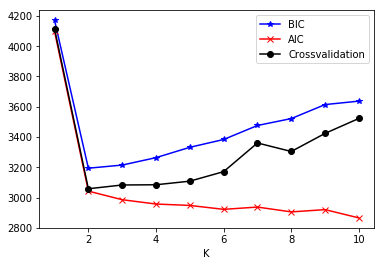

In [208]:
# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'
reps = 15                 # number of fits with different initalizations, best result will be kept
init_procedure = 'kmeans' # 'kmeans' or 'random'

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, 
                              n_init=reps, init_params=init_procedure,
                              tol=1e-6, reg_covar=1e-6, max_iter=1000).fit(X)
        
        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps, max_iter=1000).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            
# Plot results
figure(1);
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

# Maxclust is the number of clusters that results in the best goodness of fit, by the negative log likelihood measure
Maxclust = np.argmin(CVE) + 1
print('The number of clusters chosen is {0}'.format(Maxclust))

We will need to specify the number of multivariate normal distributions (i.e. clusters), __*K*__, which we expect for the model to fit. This number can be best allocated using a cross-validation approach for model feature selection, where we have split our data into 10 parts: 9 parts will always be part of the ‘training’ set and 1 part will represent the ‘testing’ set, and these sets will be shuffled in 10 consecutive iterations. Within each of these set iterations and for each __*K*__ (selected within a range from 1 to 10), we will compute a Gaussian Mixture Model on the training set and compute the negative log likelihood of the testing set point distributions. The __*K*__ which minimizes this value should be the one to be selected (since minimizing the log likelihood is directly proportional to maximizing the total likelihood of the density areas). Besides this, we may also compute the BIC and AIC measurements upon the entirety of the dataset matrix (i.e. we don’t compute these using CV), and minimizing their results should also relate to achieving best clustering performance. Figure 1 shows that, for our dataset, the number of clusters which minimizes the negative log likelihood should be selected as __*K = 2*__.

As we may see from Figure 1, the BIC measurement penalizes the number of model parameters according to the log likelihood, reducing the chance of overfitting, and, reading from the BIC curve, we find that the optimal number of multivariate distributions in GMM should be 2. The same result, __*K = 2*__, can be read from the cross-validation negative log likelihood curve. The AIC curve shows small improvements even after increasing the __*K*__, however, we argue that these results are not significant enough to account for, compared with the very large trends shown from the other two curves if we increase __*K*__. Figure 2 shows how the GMM clustering would look like upon the first two features of the dataset. We admit that the similar dark coloring for both clusters is not a good visualization choice. This is due to the implementation within the toolbox function _clusterplot_ and, while we have tried to understand how to modify its colors, it appears the mathematical algorithm behind color computation according to the necessary number of clusters is beyond our current understanding.

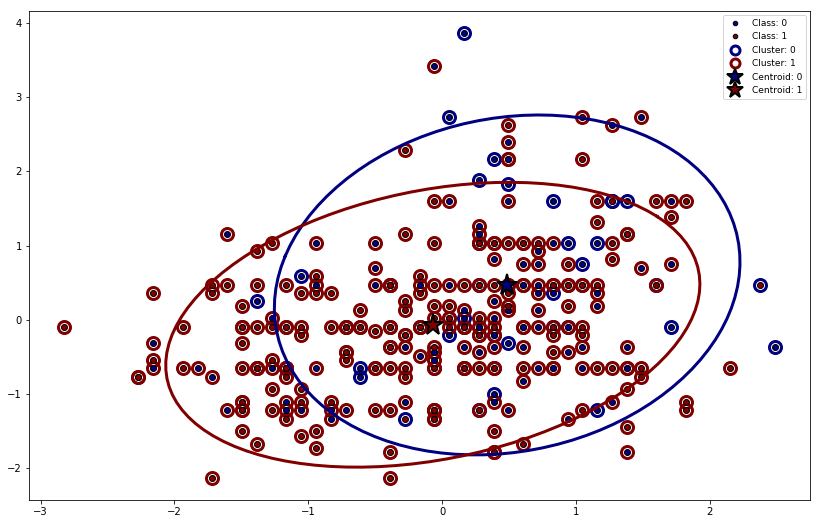

In [98]:
# Number of clusters
K = Maxclust
cov_type = 'full' # e.g. 'full' or 'diag'

# define the initialization procedure (initial value of means)
initialization_method = 'kmeans' #  'random' or 'kmeans'
# random signifies random initiation, kmeans means we run a K-means and use the
# result as the starting point. K-means might converge faster/better than  
# random, but might also cause the algorithm to be stuck in a poor local minimum 

# type of covariance, you can try out 'diag' as well
reps = 1
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=K, covariance_type=cov_type, n_init=reps, 
                      tol=1e-6, reg_covar=1e-6, init_params=initialization_method).fit(X)
cls = gmm.predict(X)    
# extract cluster labels
cds = gmm.means_        
# extract cluster centroids (means of gaussians)
covs = gmm.covariances_

# Plot results:

# In case the number of features != 2, then a subset of features most be plotted instead.
figure(figsize=(14,9))
idx = [0,1] # feature index, choose two features to use as x and y axis in the plot
clusterplot(X[:,idx], clusterid=cls, centroids=cds[:,idx], y=y, covars=covs[:,idx,:][:,:,idx])
show()

It's important to note that clusters do not necessarily have to match the classes in our dataset. Clustering will look for patterns in the data which may not always be the same as those obtained when grouping the data by the class labels. The GMM is able to extract the same number of clusters as defined by our labels (i.e. 2 labels in our y variable, and 2 clusters), but it is difficult to say whether it is a better model or not. In any case, our goal in unsupervised learning would not be to learn the class labels, but to find some structure in our data regardless of such labeling.

### _Hierarchical Clustering_

The hierarchical clustering uses a dissimilarity measure and a linkage function to interpret, link and accumulate different points together in a hierarchical manner. Again, the initial data matrix __*X*__ was standardized, after which we perform data analysis on 60 different types of hierarchical clusters generated from using 20 different linkage function metrics and 3 dissimilarity methods for each. The linkage functions metrics used are taken from scipy’s pdist computational method, and they are: {'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean'}. The three dissimilarity measures which were used for cluster grouping are: {'single', 'complete', 'average'}.

We are interested in choosing a dissimilarity measure which constructs hierarchically recursive clusters of approximately equal sizes, since that is also how our data looks like. However, as we have noticed from analyzing the 60 hierarchical clusters, very many of them tend to use linkage metrics which overfit on the data, generating leaf clusters where there is a vast majority of points separated into a cluster and one or a few points placed in another.

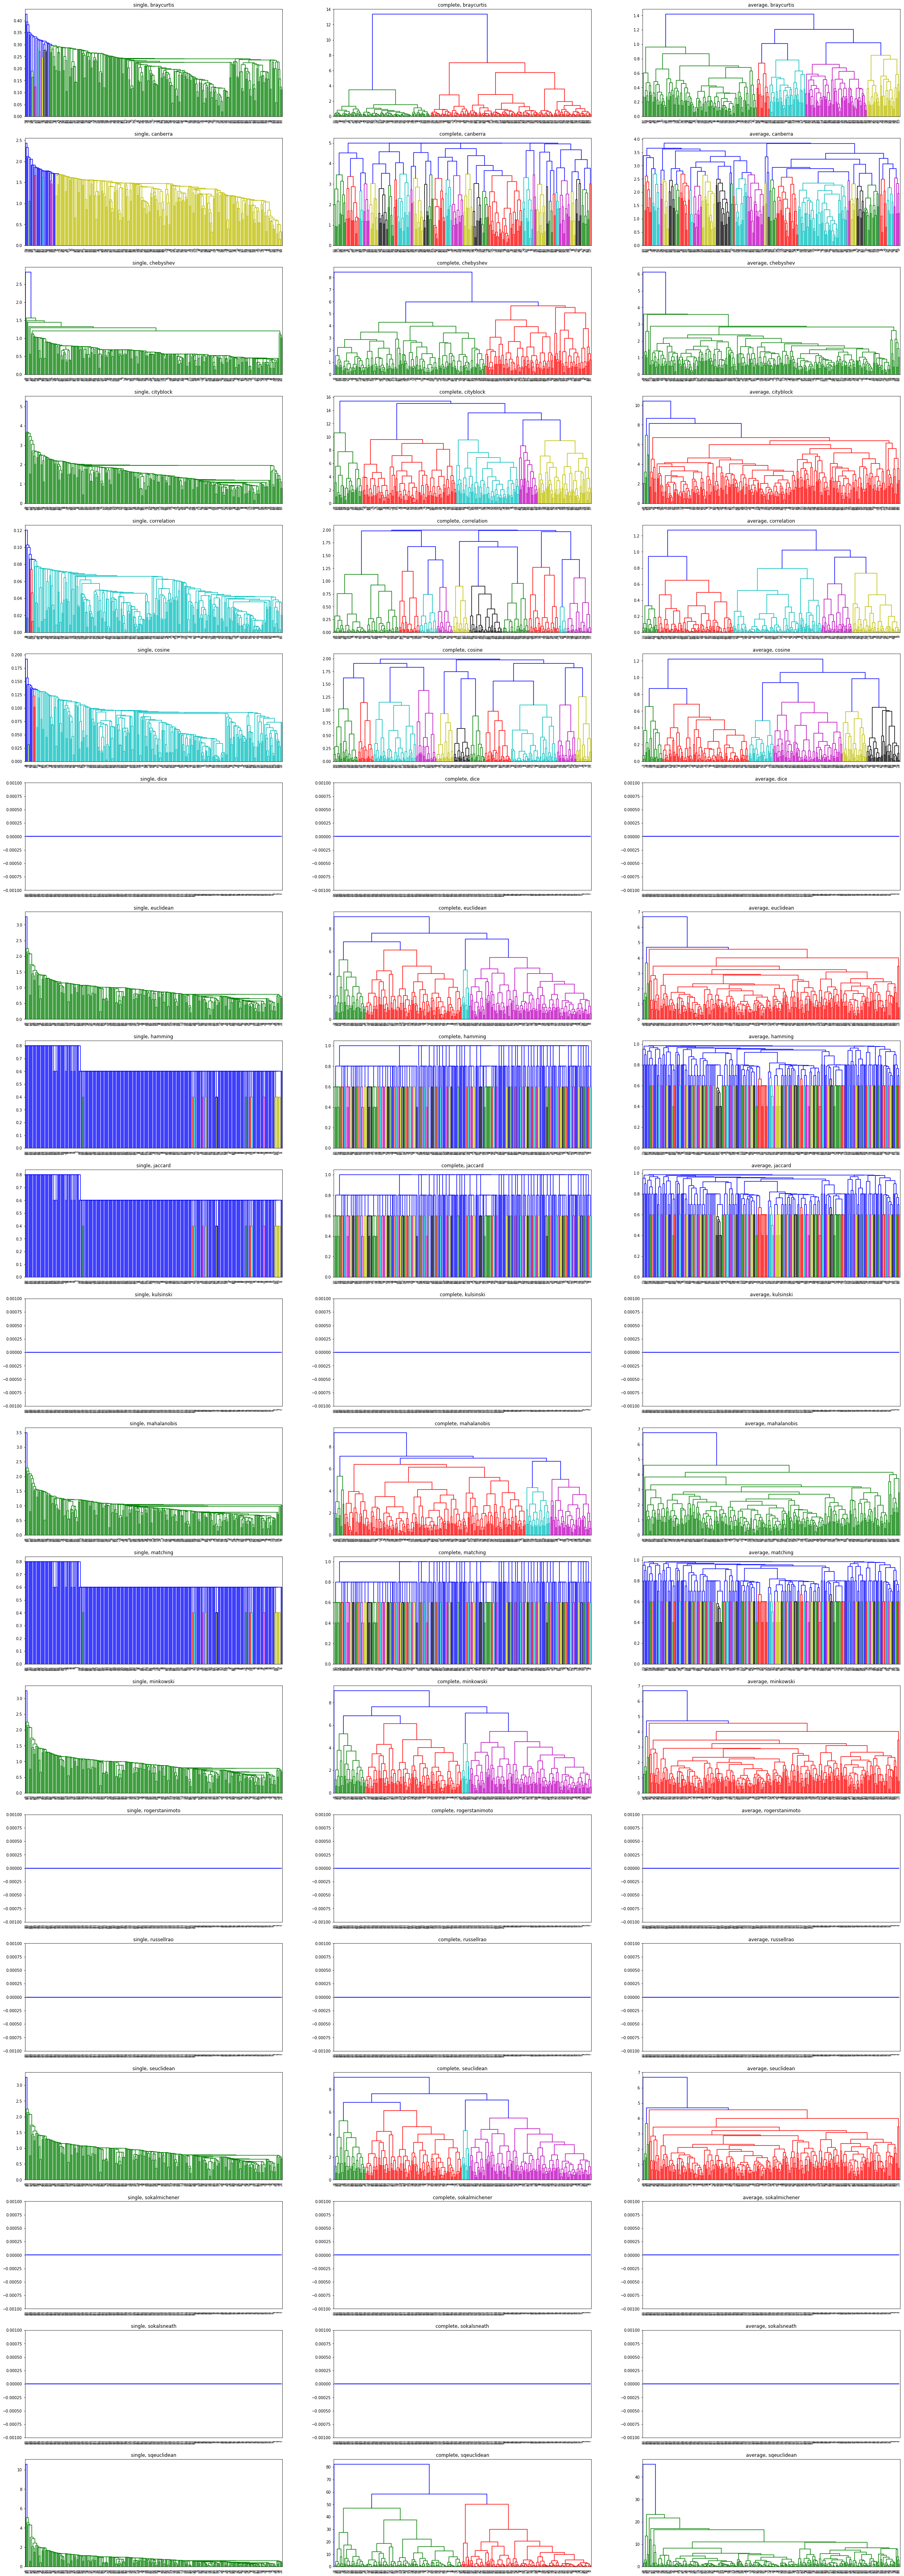

In [136]:
# Perform hierarchical/agglomerative clustering on data matrix
linkage_method = ['single', 'complete', 'average']
linkage_metric = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']
plt.figure(figsize = (40,120))

# Compute clustering by thresholding the dendrogram
for j in range(len(linkage_metric)):
    for i in range(len(linkage_method)):
        Z = linkage(X, method = linkage_method[i], metric = linkage_metric[j])
        
        plt.subplot(len(linkage_metric), len(linkage_method), j*3 + (i+1))
        dendrogram(Z, truncate_mode = 'level', p=0)
        plt.title(linkage_method[i] + ', ' + linkage_metric[j])

Out of all the dendrograms computed, we have identified that, for our dataset, the ‘complete’ and ‘average’ methods combined with Bray-Curtis or correlation metrics provide assignment of nearly equally large parts of the data to each cluster. These results can all be seen in Figure 4. Upon a closer look, we may see that the ‘average’ clustering grouping method is still overfitting on the data, therefore the most balanced clustering results can be obtained by taking farthest-neighbor clustering together with Bray-Curtis or correlation metrics. Most of these graphs show that almost equal clusters will be received by ‘cutting the dendrogram’ (i.e. selecting the __*K*__) to 2 or 4 clusters.

### _Performance evaluation of clustering methods_

Lastly here, we will try to cut the above-mentioned four most representative dendrograms (i.e. the ones using the farthest-neighbor clustering method) using the optimal cutoff value found from the GMM cross-validation model selection, namely _**K = 2**_ clusters. Now, the performance of the GMM versus the four hierarchical clustering models is evaluated using the Rand index, Jaccard index and Normalized Mutual Information (NMI) metrics. Higher values in any of the three scores indicate how similar the clustering is compared to our actual classes.

In [97]:
covar_type = 'full'
reps = 15                 # number of fits with different initalizations, best result will be kept
init_procedure = 'random' # 'kmeans' or 'random'

gmm = GaussianMixture(n_components = Maxclust, covariance_type = covar_type, n_init = reps, max_iter = 1000).fit(X)
cls = gmm.predict(X)
# compute cluster validities:
Rand, Jaccard, NMI = clusterval(y, cls)    
        
    
print('Cluster validation for Maxclust {0} using Rand is: {1}'.format(Maxclust, Rand))
print('Cluster validation for Maxclust {0} using Jaccard is: {1}'.format(Maxclust, Jaccard))
print('Cluster validation for Maxclust {0} using NMI is: {1}'.format(Maxclust, NMI))

Cluster validation for Maxclust 2 using Rand is: 0.5203160787906551
Cluster validation for Maxclust 2 using Jaccard is: 0.45232740585774056
Cluster validation for Maxclust 2 using NMI is: 0.048681394530595924


Cluster validation for Maxclust 2 using Rand is: 0.7050160329821347
Cluster validation for Maxclust 2 using Jaccard is: 0.5444609507640068
Cluster validation for Maxclust 2 using NMI is: 0.32908453877632715


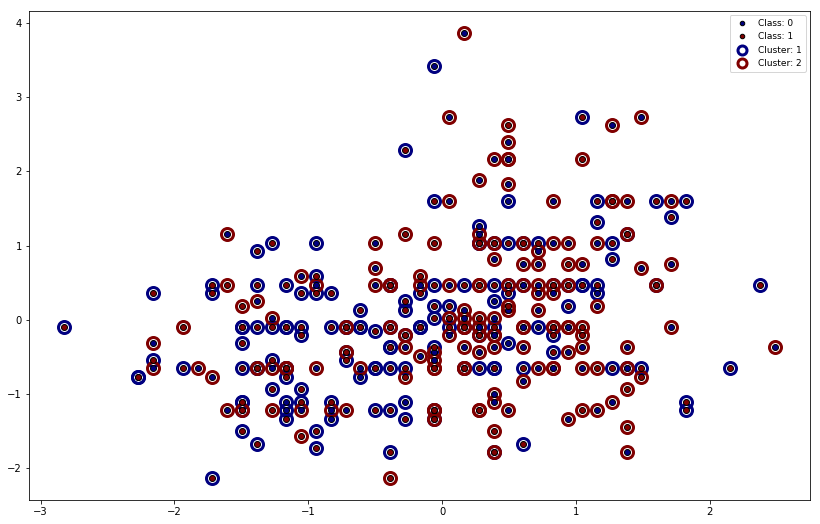

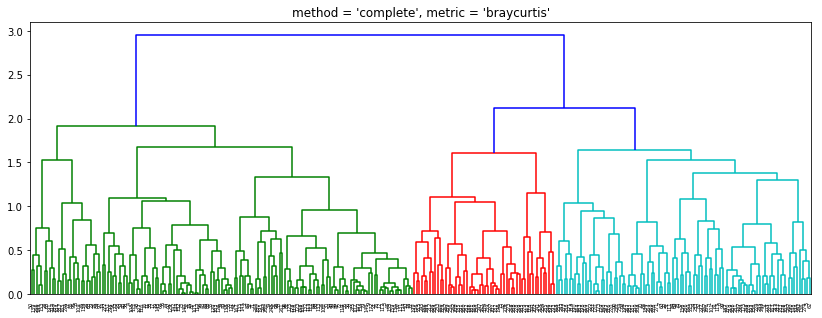

In [164]:
Z = linkage(X, method = 'complete', metric = 'braycurtis')

# Compute and display clusters by thresholding the dendrogram
cls = fcluster(Z, criterion=  'maxclust', t = Maxclust)
figure(figsize = (14,9))
clusterplot(X, cls.reshape(cls.shape[0],1), y = y)

# compute cluster validities:
Rand, Jaccard, NMI = clusterval(y, cls)  

print('Cluster validation for Maxclust {0} using Rand is: {1}'.format(Maxclust, Rand))
print('Cluster validation for Maxclust {0} using Jaccard is: {1}'.format(Maxclust, Jaccard))
print('Cluster validation for Maxclust {0} using NMI is: {1}'.format(Maxclust, NMI))

# Display dendrogram
max_display_levels = 0
figure(figsize = (14,5))
dendrogram(Z, truncate_mode='level', p=max_display_levels)
plt.title(str("method = 'complete', metric = 'braycurtis'"))

show()

Cluster validation for Maxclust 2 using Rand is: 0.6921667430142007
Cluster validation for Maxclust 2 using Jaccard is: 0.5331712400138937
Cluster validation for Maxclust 2 using NMI is: 0.29873838761373256


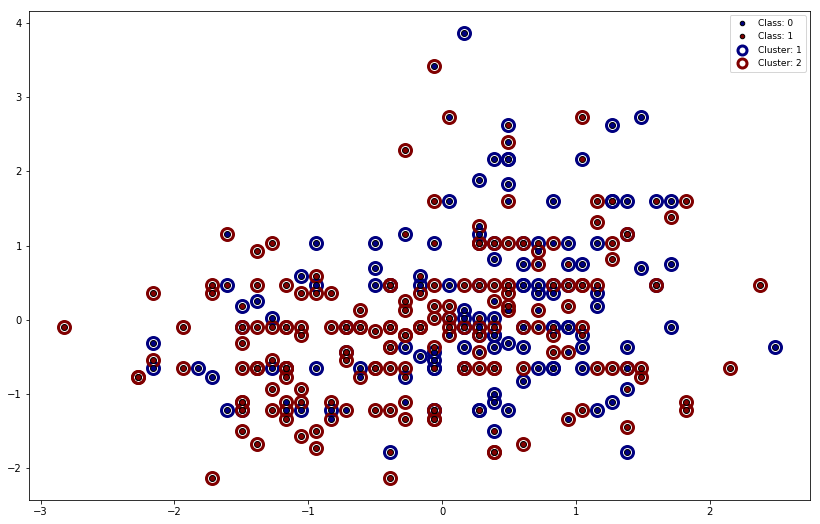

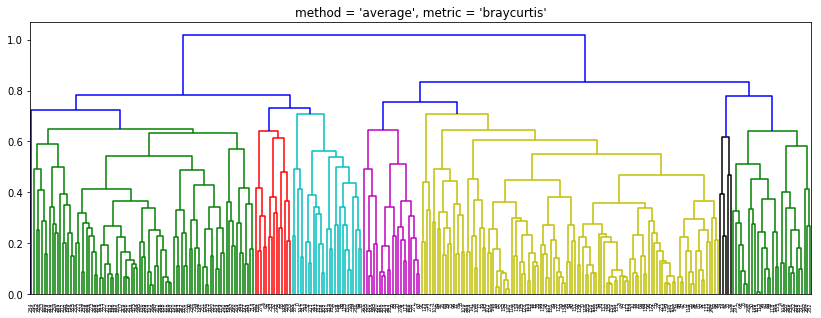

In [165]:
Z = linkage(X, method = 'average', metric = 'braycurtis')

# Compute and display clusters by thresholding the dendrogram
cls = fcluster(Z, criterion = 'maxclust', t = Maxclust)
figure(figsize = (14,9))
clusterplot(X, cls.reshape(cls.shape[0],1), y = y)

# compute cluster validities:
Rand, Jaccard, NMI = clusterval(y, cls)  

print('Cluster validation for Maxclust {0} using Rand is: {1}'.format(Maxclust, Rand))
print('Cluster validation for Maxclust {0} using Jaccard is: {1}'.format(Maxclust, Jaccard))
print('Cluster validation for Maxclust {0} using NMI is: {1}'.format(Maxclust, NMI))

# Display dendrogram
max_display_levels = 0
figure(figsize = (14,5))
dendrogram(Z, truncate_mode = 'level', p = max_display_levels)
plt.title(str("method = 'average', metric = 'braycurtis'"))

show()

Cluster validation for Maxclust 2 using Rand is: 0.6879752633989922
Cluster validation for Maxclust 2 using Jaccard is: 0.533203125
Cluster validation for Maxclust 2 using NMI is: 0.2984961751705719


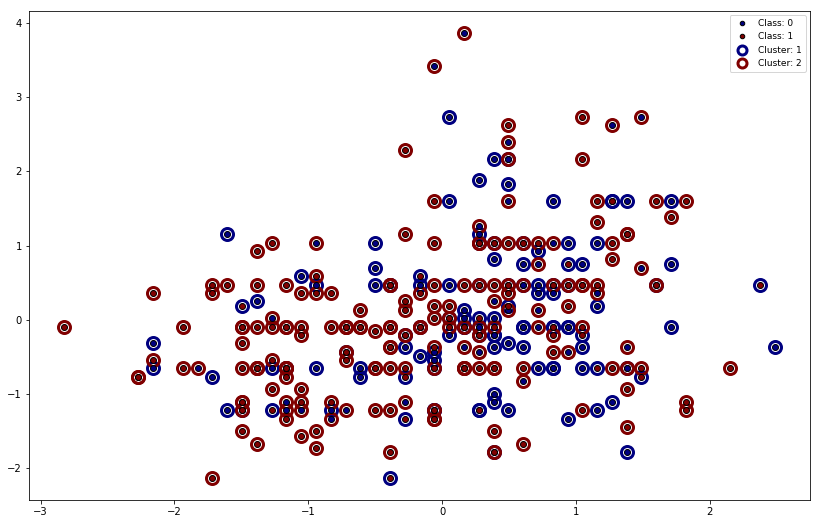

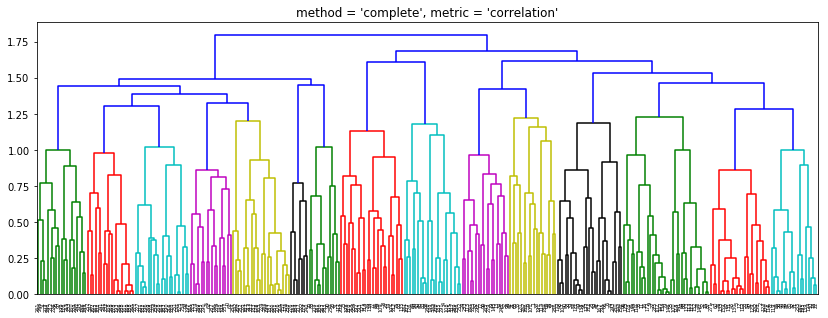

In [166]:
Z = linkage(X, method = 'complete', metric = 'correlation')

# Compute and display clusters by thresholding the dendrogram
cls = fcluster(Z, criterion=  'maxclust', t = Maxclust)
figure(figsize = (14,9))
clusterplot(X, cls.reshape(cls.shape[0],1), y = y)

# compute cluster validities:
Rand, Jaccard, NMI = clusterval(y, cls)  

print('Cluster validation for Maxclust {0} using Rand is: {1}'.format(Maxclust, Rand))
print('Cluster validation for Maxclust {0} using Jaccard is: {1}'.format(Maxclust, Jaccard))
print('Cluster validation for Maxclust {0} using NMI is: {1}'.format(Maxclust, NMI))

# Display dendrogram
max_display_levels = 0
figure(figsize = (14,5))
dendrogram(Z, truncate_mode='level', p=max_display_levels)
plt.title(str("method = 'complete', metric = 'correlation'"))

show()

Cluster validation for Maxclust 2 using Rand is: 0.6599175446633073
Cluster validation for Maxclust 2 using Jaccard is: 0.4927229244960711
Cluster validation for Maxclust 2 using NMI is: 0.25450757311327343


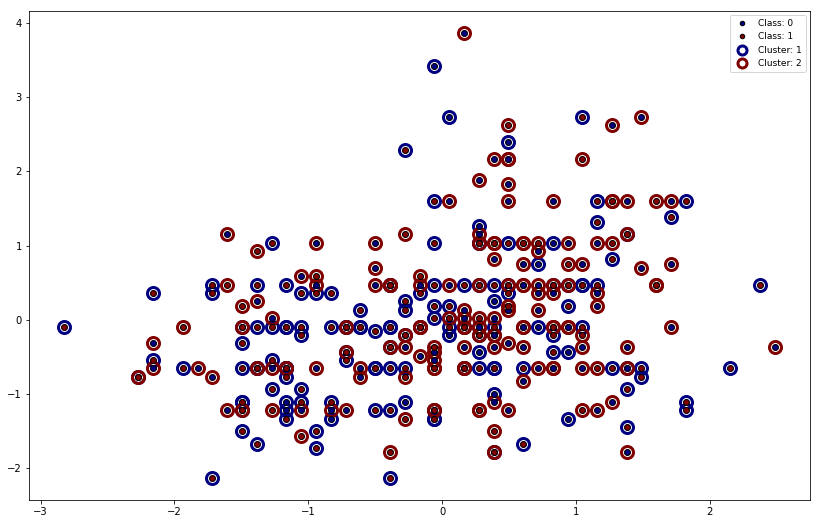

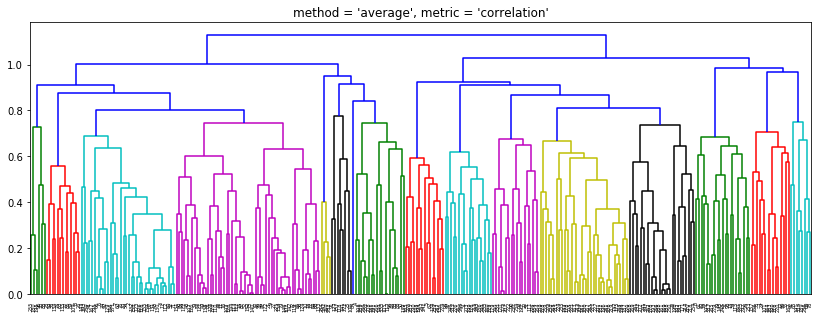

In [167]:
Z = linkage(X, method = 'average', metric = 'correlation')

# Compute and display clusters by thresholding the dendrogram
cls = fcluster(Z, criterion = 'maxclust', t = Maxclust)
figure(figsize = (14,9))
clusterplot(X, cls.reshape(cls.shape[0],1), y = y)

# compute cluster validities:
Rand, Jaccard, NMI = clusterval(y, cls)  

print('Cluster validation for Maxclust {0} using Rand is: {1}'.format(Maxclust, Rand))
print('Cluster validation for Maxclust {0} using Jaccard is: {1}'.format(Maxclust, Jaccard))
print('Cluster validation for Maxclust {0} using NMI is: {1}'.format(Maxclust, NMI))

# Display dendrogram
max_display_levels = 0
figure(figsize = (14,5))
dendrogram(Z, truncate_mode = 'level', p = max_display_levels)
plt.title(str("method = 'average', metric = 'correlation'"))

show()

We can clearly notice that thresholded hierarchical clustering provides in all four selected situations more accurate cluster similarity results than GMM does. Moreover, we notice that complete-BrayCurtis, average-BrayCurtis and complete-Correlation all give similar performance, with complete-BrayCurtis being slightly more accurate than the rest. Average-Correlation stands out as performing slightly worse similarity-wise in all three metrics.

The Gaussian Mixture Model indicated (rather erroneously) that the optimal clustering should be made of two components, one of the components being noticeably larger than the other and incorporating most data points. As such, no clear separation could have been performed, meaning that it was not possible to differentiate between the two labels of the data. The hierarchical clustering provides more reliable results and, as Figure 4 indicates, most of these dendrograms suggest splitting on 2, 4 or even perhaps 8 clusters.

### II.  Outlier/Anomaly Detection

Next in our analysis, we are interested in determining whether our observation list contains any outliers or anomalies. This data could either be mismatched/misrecorded patient data, some error within the data collection process, or perhaps they are some rather unique cases of people developing or resisting angiographic heart disease.

In order to perform anomaly detection, we will use three different density scoring methods, which will compute, observation-wise, how sparse or dense the area around a certain data point is. The lower the density around a certain point is found, the higher the probability that such a point is an anomaly/outlier within our data.

#### Loading the dataset and performing data wrangling:

In [200]:
df = pd.read_csv('heart.csv')

In [201]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [171]:
df.drop(index = (df[df.ca == 4]).index, inplace = True)

df.drop(index = (df[df.thal == 0]).index, inplace = True)
df.loc[df.thal == 1, 'thal'] = 6
df.loc[df.thal == 3, 'thal'] = 7
df.loc[df.thal == 2, 'thal'] = 3

df.loc[df.cp == 0, 'cp'] = 4
df.loc[df.cp == 3, 'cp'] = 7
df.loc[df.cp == 2, 'cp'] = 3
df.loc[df.cp == 1, 'cp'] = 2
df.loc[df.cp == 7, 'cp'] = 1

df.loc[df.slope == 2, 'slope'] = 3
df.loc[df.slope == 1, 'slope'] = 2
df.loc[df.slope == 0, 'slope'] = 1

In [172]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [173]:
cat_col = pd.get_dummies(df.sex)
cat_col.columns = ['sex_female', 'sex_male']

df = df.drop('sex', axis = 1)

df = df.join(cat_col)

In [174]:
cat_col = pd.get_dummies(df.cp)
cat_col.columns = ['cp_typical', 'cp_atypical', 'cp_non_anginal', 'cp_asymptomatic']

df = df.drop('cp', axis = 1)

df = df.join(cat_col)

In [175]:
cat_col = pd.get_dummies(df.fbs)
cat_col.columns = ['fbs_false', 'fbs_true']

df = df.drop('fbs', axis = 1)

df = df.join(cat_col)

In [176]:
cat_col = pd.get_dummies(df.restecg)
cat_col.columns = ['restecg_normal', 'restecg_st_t', 'restecg_hypertrophy']

df = df.drop('restecg', axis = 1)

df = df.join(cat_col)

In [177]:
cat_col = pd.get_dummies(df.exang)
cat_col.columns = ['exang_no', 'exang_yes']

df = df.drop('exang', axis = 1)

df = df.join(cat_col)

In [178]:
cat_col = pd.get_dummies(df.slope)
cat_col.columns = ['slope_upsloping', 'slope_flat', 'slope_downsloping']

df = df.drop('slope', axis = 1)

df = df.join(cat_col)

In [179]:
cat_col = pd.get_dummies(df['ca'], prefix = 'ca')

df = df.drop('ca', axis = 1)

df = df.join(cat_col)

In [180]:
cat_col = pd.get_dummies(df.thal)
cat_col.columns = ['thal_normal', 'thal_fixed', 'thal_reversible']

df = df.drop('thal', axis = 1)

df = df.join(cat_col)

In [181]:
y = np.array(df['target'])
df = df.drop('target', axis = 1)

X = df.to_numpy()
X = stats.zscore(X)

N = X.shape[0]
M = X.shape[1]

In [182]:
df.head()

,age,trestbps,chol,thalach,oldpeak,sex_female,sex_male,cp_typical,cp_atypical,cp_non_anginal,...,slope_upsloping,slope_flat,slope_downsloping,ca_0,ca_1,ca_2,ca_3,thal_normal,thal_fixed,thal_reversible
0,63,145,233,150,2.3,0,1,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
2,41,130,204,172,1.4,1,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,0,1,1,0,0,0,1,0,0
4,57,120,354,163,0.6,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


### _Gaussian Kernel Density_

Computing the density using the Gaussian Kernel Density requires the selection of a kernel width __*λ*__, also called bandwidth, which can be similarly associated to the sensitivity of the probability formula with respect to highly or weakly populated areas of data. A too high kernel bandwidth can easily overfit, while a too low bandwidth will make the density model very rigid to any differences between high-density and low-density areas.

A way to select the ideal width __*λ*__ is through leave-one-out cross-validation method, where we compute the log-likelihood probability of the test-set data points density estimations, and we will efficiently select the λ which maximizes this log-likelihood measurement. Having found that, for our dataset, the optimal bandwidth is __*λ = 0.5*__, we now proceed to present the 20 data points with lowest density, and potential outliers.

In [185]:
outlier_observations = np.zeros((3,20))

Optimal estimated width is: 0.50



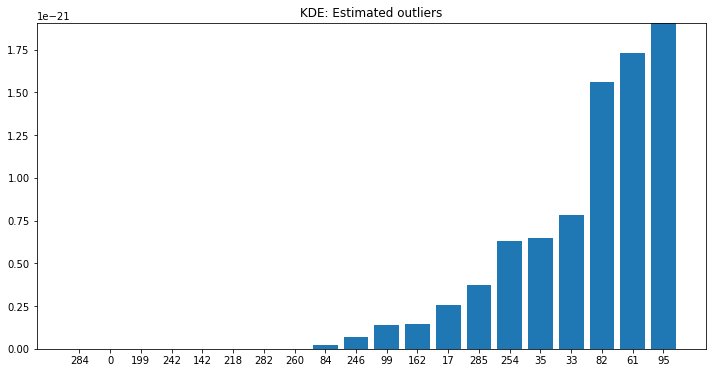

In [186]:
### Gaussian Kernel density estimator

# cross-validate kernel width by leave-one-out-cross-validation
# (efficient implementation in gausKernelDensity function)
# evaluate for range of kernel widths

widths = X.var(axis=0).max() * (2.0**np.arange(-10,3))
logP = np.zeros(np.size(widths))

for i,w in enumerate(widths):
#    print('Fold {:2d}, w={:f}'.format(i,w))
   density, log_density = gausKernelDensity(X,w)
   logP[i] = log_density.sum()

# figure(1)
# title('Log likelihood of data using various kernel widths')
# plot(widths, logP)

val = logP.max()
ind = logP.argmax()
width = widths[ind]
print('Optimal estimated width is: {0:.2f}'.format(width))

# evaluate density for estimated width
density, log_density = gausKernelDensity(X,width)

# Sort the densities
i = (density.argsort(axis=0)).ravel()
density = density[i].reshape(-1,)

# Plot possible outliers
i = i.astype(str)

print()

plt.figure(figsize = [12, 6])
plt.title('KDE: Estimated outliers')
for k in range(0,20):
    plt.bar(i[k], density[k], color = sb.color_palette()[0])
    
outlier_observations[0,:] = i[:20]

###  _K-Nearest Neighbors Density (KNN Density)_

The KNN density metric, unlike the KDE, does not rely on probabilities, and computes the point density using the average of the distances to the K nearest neighbors. Intuitively, the lower this average distance will be, the closer (on average) the point’s nearest neighbors will be and the area will be more densely populated with data. Therefore, the KNN density is the inverse of the average distance to the K nearest neighbors. Figure 6 shows, again, the 20 most probable outliers of our dataset.

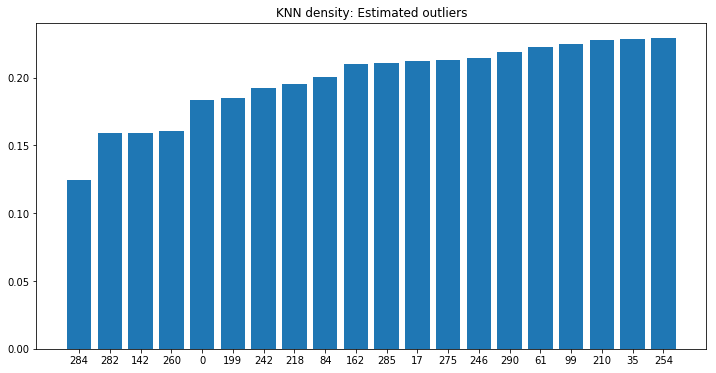

In [187]:
### K-neighbors density estimator
# Neighbor to use:
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)

density = 1./(D.sum(axis=1)/K)

# Sort the scores
i = density.argsort()
density = density[i]

# Plot possible outliers
i = i.astype(str)

print()

plt.figure(figsize = [12, 6])
plt.title('KNN density: Estimated outliers')
for k in range(0,20):
    plt.bar(i[k], density[k], color = sb.color_palette()[0])
    
outlier_observations[1,:] = i[:20]

### _K-Nearest Neighbors Average Relative Density (KNN-ARD)_

The KNN ARD metric takes the formula of the KNN density one step further, and, instead of considering which points have a sparse data density around them, the ARD formula will make these density measurements relative to what is typical for the surrounding points. Thus, if a point has a sparse data density, however its closest neighbors also will have sparse data densities, this will no longer be considered as outlier signals. Figure 7 presents the 20 data points whose area densities are behaving much differently from those of its neighbors. 

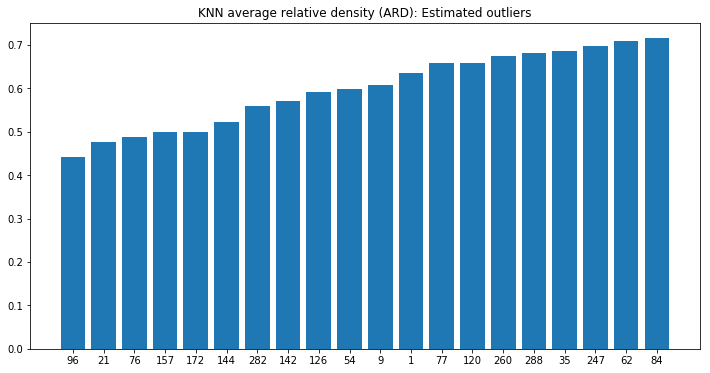

In [188]:
### K-nearest neigbor average relative density
# Compute the average relative density

knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)
density = 1./(D.sum(axis=1)/K)
avg_rel_density = density/(density[i[:,1:]].sum(axis=1)/K)

# Sort the avg.rel.densities
i_avg_rel = avg_rel_density.argsort()
avg_rel_density = avg_rel_density[i_avg_rel]

# Plot possible outliers
i_avg_rel = i_avg_rel.astype(str)

print()

plt.figure(figsize = [12, 6])
plt.title('KNN average relative density (ARD): Estimated outliers')
for k in range(0,20):
    plt.bar(i_avg_rel[k], avg_rel_density[k], color = sb.color_palette()[0])
    
outlier_observations[2,:] = i_avg_rel[:20]

### _Evaluation and high-confidence outlier detection_

From evaluating our dataset against these three outlier detection methods, we have discovered various points which are potential outliers according to each separate method. However, we cannot be entirely confident of their status as outliers due to single metric calculations. Therefore, in order to achieve high confidence in our anomaly detection patters, we should select and analyze the observations within the data matrix __*X*__ whose indexes can be found simultaneously by two or three density metrics.

In [189]:
print('Common outlier observations which were found both by Gaussian KDE and KNN density estimators are: ')
pd.Series(outlier_observations[0])[pd.Series(outlier_observations[0]).isin(outlier_observations[1]) == True].astype(int)

Common outlier observations which were found both by Gaussian KDE and KNN density estimators are: 


0     284
1       0
2     199
3     242
4     142
5     218
6     282
7     260
8      84
9     246
10     99
11    162
12     17
13    285
14    254
15     35
18     61
dtype: int32

In [190]:
print('Common outlier observations which were found both by Gaussian KDE and (KNN) ARD density estimators are: ')
pd.Series(outlier_observations[0])[pd.Series(outlier_observations[0]).isin(outlier_observations[2]) == True].astype(int)

Common outlier observations which were found both by Gaussian KDE and (KNN) ARD density estimators are: 


4     142
6     282
7     260
8      84
15     35
dtype: int32

In [191]:
print('Common outlier observations which were found both by KNN density and (KNN) ARD density estimators are: ')
pd.Series(outlier_observations[1])[pd.Series(outlier_observations[1]).isin(outlier_observations[2]) == True].astype(int)

Common outlier observations which were found both by KNN density and (KNN) ARD density estimators are: 


1     282
2     142
3     260
8      84
18     35
dtype: int32

In [192]:
print('Common outlier observations which were found by all three Gaussian KDE, KNN density and (KNN) ARD density estimators are: ')
pd.Series(outlier_observations[0])[(pd.Series(outlier_observations[0]).isin(outlier_observations[1]) == True) & (pd.Series(outlier_observations[0]).isin(outlier_observations[2]) == True)].astype(int)

Common outlier observations which were found by all three Gaussian KDE, KNN density and (KNN) ARD density estimators are: 


4     142
6     282
7     260
8      84
15     35
dtype: int32

From the above analysis, we can find that 5 observations are high-confidence outliers: indexes 35, 84, 142, 260 and 282, out of which two entries correspond to patients without heart disease, and three correspond to patients with the disease. Further investigation upon such data would be appropriate, however, since we do not have the necessary competencies in the field of cardiology in order to understand causalities between the various angiographic variables present in our dataset, we will direct this analysis to people initiated within the topic.

### III.  Association Mining

The purpose behind association mining is to find frequent and highly-confident patterns within the large number of features in a dataset. In our case, it would correspond to finding relations between body parameters related to the human heart. Considering that, we decide to one-out-of-K encode all of our categorical variables, and add the class label feature also in our final data matrix, since we would be very interested in finding patters related to the disease variable as well.

#### Loading the dataset and performing data wrangling:

In [208]:
df = pd.read_csv('heart.csv')

In [209]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [210]:
df.drop(index = (df[df.ca == 4]).index, inplace = True)

df.drop(index = (df[df.thal == 0]).index, inplace = True)
df.loc[df.thal == 1, 'thal'] = 6
df.loc[df.thal == 3, 'thal'] = 7
df.loc[df.thal == 2, 'thal'] = 3

df.loc[df.cp == 0, 'cp'] = 4
df.loc[df.cp == 3, 'cp'] = 7
df.loc[df.cp == 2, 'cp'] = 3
df.loc[df.cp == 1, 'cp'] = 2
df.loc[df.cp == 7, 'cp'] = 1

df.loc[df.slope == 2, 'slope'] = 3
df.loc[df.slope == 1, 'slope'] = 2
df.loc[df.slope == 0, 'slope'] = 1

In [211]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [212]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,0,150,0,2.3,1,0,6,1
1,37,1,3,130,250,0,1,187,0,3.5,1,0,3,1
2,41,0,2,130,204,0,0,172,0,1.4,3,0,3,1
3,56,1,2,120,236,0,1,178,0,0.8,3,0,3,1
4,57,0,4,120,354,0,1,163,1,0.6,3,0,3,1


In [213]:
cat_col = pd.get_dummies(df.sex)
cat_col.columns = ['sex_female', 'sex_male']

df = df.drop('sex', axis = 1)

df = df.join(cat_col)

In [214]:
cat_col = pd.get_dummies(df.cp)
cat_col.columns = ['cp_typical', 'cp_atypical', 'cp_non_anginal', 'cp_asymptomatic']

df = df.drop('cp', axis = 1)

df = df.join(cat_col)

In [215]:
cat_col = pd.get_dummies(df.fbs)
cat_col.columns = ['fbs_false', 'fbs_true']

df = df.drop('fbs', axis = 1)

df = df.join(cat_col)

In [216]:
cat_col = pd.get_dummies(df.restecg)
cat_col.columns = ['restecg_normal', 'restecg_st_t', 'restecg_hypertrophy']

df = df.drop('restecg', axis = 1)

df = df.join(cat_col)

In [217]:
cat_col = pd.get_dummies(df.exang)
cat_col.columns = ['exang_no', 'exang_yes']

df = df.drop('exang', axis = 1)

df = df.join(cat_col)

In [218]:
cat_col = pd.get_dummies(df.slope)
cat_col.columns = ['slope_upsloping', 'slope_flat', 'slope_downsloping']

df = df.drop('slope', axis = 1)

df = df.join(cat_col)

In [219]:
cat_col = pd.get_dummies(df['ca'], prefix = 'ca')

df = df.drop('ca', axis = 1)

df = df.join(cat_col)

In [220]:
cat_col = pd.get_dummies(df.thal)
cat_col.columns = ['thal_normal', 'thal_fixed', 'thal_reversible']

df = df.drop('thal', axis = 1)

df = df.join(cat_col)

In [221]:
cat_col = pd.get_dummies(df.target)
cat_col.columns = ['disease_false', 'disease_true']

df = df.drop('target', axis = 1)

df = df.join(cat_col)

In [222]:
X = df.iloc[:,0:5].to_numpy()
attributeNames = list(df.iloc[:,0:5].columns)

Xbin, attributeNamesBin = binarize2(X, attributeNames)

df = pd.DataFrame(Xbin, columns = attributeNamesBin, dtype = int).join(df)

df = df.drop(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], axis = 1)

By using the efficient Apriori algorithm, we will easily compute a set of transactions between features. This transaction list can be filtered to contain only feature relations which occur with a minimum frequency (i.e. minimum support) and a minimum confidence level. Since our data is categorically encoded, we argue that the minimum support chosen should be around 50% or less (since most of the variables have at least a binary encoding, in which presence of one variable automatically negates presence of the other variable). For confidence levels, we would like a percentage as close to 100% as possible, however while still being relevant enough for our data so that a set of meaningful apriori rules are retrieved. After performing a few iterations with different values of minimum support and confidence, we have decided that a support of 45% and confidence level of 70% as minima would be appropriate for our dataset.

In [223]:
# This is a helper function that transforms a binary matrix into transactions.
# Note the format used for courses.txt was (nearly) in a transaction format,
# however we will need the function later which is why we first transformed
# courses.txt to our standard binary-matrix format.
def binary_matrix_to_transaction_vectors(X, labels=[]):
    T = []
    for i in range(X.shape[0]):
        l = np.nonzero(X[i, :])[0].tolist()
        if labels:
            l = [labels[i] for i in l]
        T.append(l)
    return T

In [224]:
# This function print the found rules and also returns a list of rules in the format:
# [(x,y), ...]
# where x -> y
def print_apriori_rules(rules):
    frules = []
    for r in rules:
        for o in r.ordered_statistics:        
            conf = o.confidence
            supp = r.support
            x = ", ".join( list( o.items_base ) )
            y = ", ".join( list( o.items_add ) )
            print("{%s} -> {%s}  (supp: %.3f, conf: %.3f)"%(x,y, supp, conf))
            frules.append( (x,y) )

In [225]:
X = df.to_numpy()
attributeNames = list(df.columns)

In [226]:
transaction_list = binary_matrix_to_transaction_vectors(X, labels = attributeNames)

In [227]:
rules = apriori(transaction_list, min_support = 0.45, min_confidence = 0.7)
print_apriori_rules(rules)

{} -> {fbs_false}  (supp: 0.861, conf: 0.861)
{age 0th-50th percentile} -> {fbs_false}  (supp: 0.459, conf: 0.866)
{ca_0} -> {disease_true}  (supp: 0.459, conf: 0.768)
{disease_true} -> {ca_0}  (supp: 0.459, conf: 0.814)
{ca_0} -> {exang_no}  (supp: 0.459, conf: 0.768)
{ca_0} -> {fbs_false}  (supp: 0.534, conf: 0.893)
{disease_true} -> {exang_no}  (supp: 0.486, conf: 0.862)
{exang_no} -> {disease_true}  (supp: 0.486, conf: 0.713)
{disease_true} -> {fbs_false}  (supp: 0.486, conf: 0.862)
{disease_true} -> {thal_normal}  (supp: 0.453, conf: 0.802)
{thal_normal} -> {disease_true}  (supp: 0.453, conf: 0.798)
{exang_no} -> {fbs_false}  (supp: 0.591, conf: 0.866)
{thal_normal} -> {exang_no}  (supp: 0.466, conf: 0.821)
{oldpeak 0th-50th percentile} -> {fbs_false}  (supp: 0.476, conf: 0.898)
{sex_male} -> {fbs_false}  (supp: 0.591, conf: 0.858)
{thal_normal} -> {fbs_false}  (supp: 0.500, conf: 0.881)
{trestbps 0th-50th percentile} -> {fbs_false}  (supp: 0.497, conf: 0.875)


We have discovered a list of 17 association rules, which are both frequent item sets and highly-confident rules. Most of such rules have very high confidence (above 85%), while the frequency of rules is varying from ~45% to ~50%, with the exception of three highly frequent rules with support of 86%, 59% and 59% respectively.

Through analyzing the above-mentioned rules, we do find that some are very relevant and intuitive in relation to our dataset’s problem formulation. For example, rule 3 says that ca0 is confidently frequent associated with angiographic disease, and, from the literature, we find that, indeed, not having any major vessels colored by the fluoroscopy does lead to a bad sign of heart disease. This is even more so confident through rule 4, which mentions that, equivalently, having angiographic heart disease will lead to no major vessels being colored by fluoroscopy test (i.e. ca0).

Some of the more amusing and also questionable rules include, for example, rule 15, where it is specified that almost 90% of the male patients did not have high amounts of fasting blood sugar. However, if we take a look at rule 1, since we know that the empty list ‘{}’ refers to all the transactions of the whole dataset, we find that 86% of the time (meaning 86% of all patients), our recorded patients do not have high amounts of fasting blood sugar. So, from the two previous rules, does that mean that males are less likely to have high fasting blood sugar, or that most patients/people are less likely to have high fasting blood sugar, or that our dataset consists mainly of male patients? A quick look through the value counts of the gender variable reveals that the last possibility is likely the true scenario happening in our case, since we found that the dataset contains 207 male patients and 96 female patients. That is a male distribution of ~69%, which is less than 86%, suggesting that there are also some other phenomena which should be taken into account, however the male dominance within the dataset is a clear explanator for the two above-mentioned association rules.

### IV.  Analysis of findings - Discussion and Conclusion

From our analysis, we have determined results from various techniques of unsupervised learning upon the UCL heart disease dataset. It was concluded that hierarchical clustering of our dataset is more appropriate than the GMM approach, and that the appropriate number of clusters may be 2 or more (perhaps 4 or 8, according to the hierarchical clustering). With respect to outliers, using the different point density estimation methods, we have performed anomaly detection, which resulted in 5 high-confidence outliers being identified. Lastly, through performing association mining, we have discovered 17 frequent rules with high-confidence levels, such as that angiographic disease is predicted from not having any major vessels colored in fluoroscopy. However, even within these high-confidence rules, we must try to be slightly careful and deeply understand exactly what is generating this high frequency or confidence in the rules: is it dataset bias or is it real-world phenomena?

### V.  Bibliography

[1] Frese, A. and Sbirna, S. (2019), “UCL Heart Disease - Data: Feature extraction and visualization”.